In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys


from importlib import reload

sys.path.append('/content/drive/MyDrive/Colab Notebooks/fidle-master')
import fidle.pwk as pwk

run_dir = '/content/drive/MyDrive/Colab Notebooks'


pd.set_option('display.max_rows',200)

In [ ]:
 # ---- About dataset (no need to change)
#
dataset_dir      = '/content/drive/MyDrive/Colab Notebooks'                  # Enhanced dataset is very small, so ./data in a good choice :-)
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['Température','mois_de_l_annee','Humidité']
features_len     = len(features)

# ---- About training (Can be changed !)
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 32
batch_size       = 64
epochs           = 10
fit_verbosity    = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [ ]:
 pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs', 'fit_verbosity')

In [ ]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train.head(31))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

pwk.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)

In [ ]:
# ---- Train generator

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x[0]) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y[0]) :')
pwk.np_print(y[0])

In [ ]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') ) #bon ca doit pas etre normal
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               41600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 41,903
Trainable params: 41,903
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pwk.mkdir(run_dir)
save_dir = f'{run_dir}/best_model.h6'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [ ]:
 model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

In [ ]:
 pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/10
442/442 [==============================] - ETA: 0s - loss: 0.3509 - mae: 0.4346INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


442/442 [==============================] - 36s 67ms/step - loss: 0.3509 - mae: 0.4346 - val_loss: 0.1406 - val_mae: 0.2580
Epoch 2/10
442/442 [==============================] - ETA: 0s - loss: 0.1483 - mae: 0.2782INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


442/442 [==============================] - 26s 59ms/step - loss: 0.1483 - mae: 0.2782 - val_loss: 0.0928 - val_mae: 0.2031
Epoch 3/10
441/442 [============================>.] - ETA: 0s - loss: 0.1133 - mae: 0.2407INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


442/442 [==============================] - 25s 57ms/step - loss: 0.1133 - mae: 0.2407 - val_loss: 0.0781 - val_mae: 0.1886
Epoch 4/10
442/442 [==============================] - ETA: 0s - loss: 0.1044 - mae: 0.2293INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


442/442 [==============================] - 27s 60ms/step - loss: 0.1044 - mae: 0.2293 - val_loss: 0.0696 - val_mae: 0.1652
Epoch 5/10
442/442 [==============================] - ETA: 0s - loss: 0.0976 - mae: 0.2206INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


442/442 [==============================] - 26s 58ms/step - loss: 0.0976 - mae: 0.2206 - val_loss: 0.0675 - val_mae: 0.1599
Epoch 6/10
442/442 [==============================] - 24s 53ms/step - loss: 0.0929 - mae: 0.2145 - val_loss: 0.0698 - val_mae: 0.1679
Epoch 7/10
442/442 [==============================] - ETA: 0s - loss: 0.0901 - mae: 0.2102INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


442/442 [==============================] - 26s 58ms/step - loss: 0.0901 - mae: 0.2102 - val_loss: 0.0647 - val_mae: 0.1580
Epoch 8/10
442/442 [==============================] - ETA: 0s - loss: 0.0874 - mae: 0.2066INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


442/442 [==============================] - 26s 59ms/step - loss: 0.0874 - mae: 0.2066 - val_loss: 0.0624 - val_mae: 0.1561
Epoch 9/10
442/442 [==============================] - 24s 54ms/step - loss: 0.0853 - mae: 0.2038 - val_loss: 0.0637 - val_mae: 0.1561
Epoch 10/10
441/442 [============================>.] - ETA: 0s - loss: 0.0839 - mae: 0.2020INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/best_model.h6/assets


442/442 [==============================] - 26s 58ms/step - loss: 0.0839 - mae: 0.2020 - val_loss: 0.0609 - val_mae: 0.1569

Duration :  00:04:25 201ms


In [ ]:
 pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history') 

In [ ]:
 loaded_model = tf.keras.models.load_model(f'{run_dir}/best_model.h6')

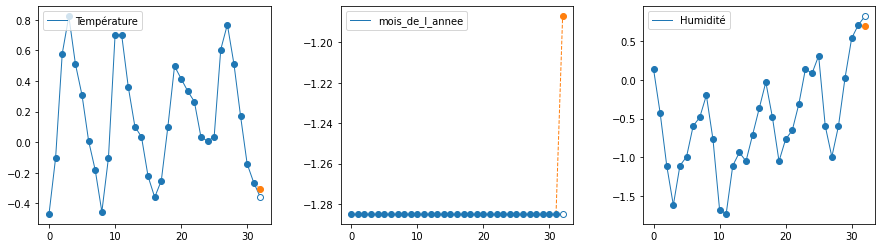

In [ ]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')

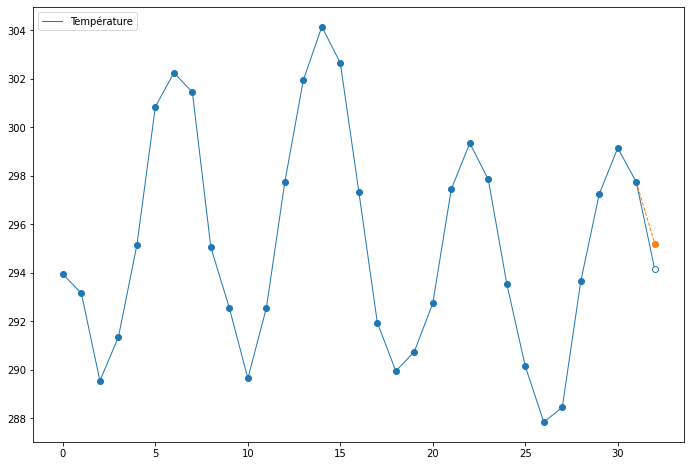

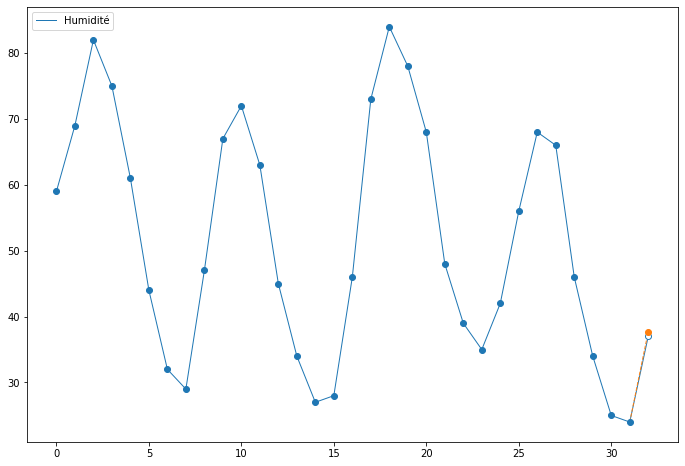

Gap between prediction and reality : 258.20 °C


In [ ]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=0 #la feature "température"
feat2=2 #la feature 'humidité"

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat2],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat2]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')